# Multimodal Evals

LangSmith + LangChain support multimodal evaluation. Below is an example evaluating gemini. If you click through to any of the traced LLM calls, it will look like this:

![LLM run](./img/resulting_run.jpg)

In [1]:
# %pip install --upgrade --quiet  langsmith langchain langchain-google-genai

In [2]:
import getpass
import os


def _get_env(var: str):
    os.environ[var] = os.environ.get(var) or getpass.getpass(f"{var}: ")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
_get_env("LANGCHAIN_API_KEY")
_get_env("LANGCHAIN_API_KEY")

In [3]:
import langsmith

client = langsmith.Client()

#### Create Dataset

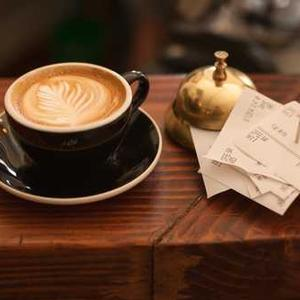

In [4]:
import requests
from IPython.display import Image

image_url = "https://picsum.photos/seed/flopsum/300/300"

content = requests.get(image_url).content
Image(content)

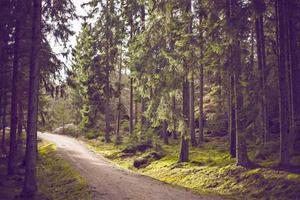

In [5]:
# Not actually a kitten
image_url = "https://picsum.photos/seed/kitten/300/200"
image_content = requests.get(image_url).content
Image(image_content)

In [6]:
import base64

dataset_name = "Multimodal Example"
if not client.has_dataset(dataset_name=dataset_name):
    ds = client.create_dataset(dataset_name)
    client.create_examples(
        inputs=[
            # We can support urls
            {"image": "https://picsum.photos/seed/flopsum/300/300"},
            # As well as base64 encoded images
            {"image": base64.b64encode(image_content).decode("utf-8")},
        ],
        outputs=[{"label": "espresso"}, {"label": "woods"}],
        dataset_name=dataset_name,
    )

## Chain to test

Let's try out gemini pro's multimodal capability.

In [15]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    HarmBlockThreshold,
    HarmCategory,
)

llm = ChatGoogleGenerativeAI(
    model="gemini-pro-vision",
    # Disable spurious safety filters
    safety_settings={
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    },
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "user",
            [
                {"type": "text", "text": "What is this a picture of?"},
                {"type": "image_url", "image_url": "{image_value}"},
            ],
        ),
    ]
)

chain = prompt | llm

chain.invoke({"image_value": image_url})

AIMessage(content=' This is a picture of a path through a pine forest.')

## Evaluator

In [16]:
from langsmith.evaluation import run_evaluator


@run_evaluator
def prediction_contains(run, example):
    prediction = run.outputs["output"]
    label = example.outputs["label"]
    score = label in prediction.lower()
    return {"key": "prediction_contains", "score": score}

## Evaluate

Now it's time to put it all together.

In [17]:
# Our may expect different keys than those stored in the dataset
def to_test(inputs: dict):
    img = inputs["image"]
    if not img.startswith("https"):
        img = f"data:image/png;base64,{img}"
    result = chain.invoke({"image_value": img})
    return {"output": result.content}

In [18]:
from langchain.smith import RunEvalConfig

test_results = client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=to_test,
    evaluation=RunEvalConfig(
        custom_evaluators=[prediction_contains],
    ),
)

View the evaluation results for project 'warm-sky-29' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/104245a1-004e-41fc-bfdd-73554e5fd316/compare?selectedSessions=02d1e70b-cc80-47da-8209-3952c16223fe

View all tests for Dataset Multimodal Example at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/104245a1-004e-41fc-bfdd-73554e5fd316
[------------------------------------------------->] 2/2

In [19]:
test_results.to_dataframe()

,inputs.image,outputs.output,reference.label,feedback.prediction_contains,error,execution_time,run_id
1170f58f-5239-4d93-827f-67d6b720522f,/9j/4QDeRXhpZgAASUkqAAgAAAAGABIBAwABAAAAAQAAAB...,This is a picture of a dirt road in a forest.,woods,False,None,4.059343,feb6582c-4a6d-4cc1-bb9f-5e2566ffaf62
e1ce282f-a22c-44e2-8740-1e4176afa940,https://picsum.photos/seed/flopsum/300/300,This is a picture of a cup of coffee with a s...,espresso,False,None,4.107023,b10eb978-d1a1-41a9-957b-2126e719728c


![regression graph](./img/test_graph.jpg)